In [4]:
import pandas as pd
import requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon as mplPolygon
from cartopy.mpl.geoaxes import GeoAxes
from metpy.plots import USCOUNTIES
import datetime
import re
import numpy as np

C:\Users\Tony\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [5]:
def fetch_data(wfos):
    dfs = []
    date = None  # Initialize date variable
    
    for wfo in wfos:
        url = f'https://mesonet.agron.iastate.edu/api/1/cow.json?wfo={wfo}&begints=2016-07-21T00:00:00Z&endts=2016-07-21T18:00:00Z&hailsize=1&wind=58&phenomena=TO&phenomena=SV&phenomena=MA&phenomena=FF&phenomena=DS&lsrbuffer=15&warningbuffer=1'
        
        # Extracting date portion from the URL
        date_match = re.search(r'begints=(\d{4}-\d{2}-\d{2})', url)
        if date_match:
            date = date_match.group(1)  # Assign date only if it's not assigned yet
        else:
            raise ValueError("Date not found in the URL")
        
        response = requests.get(url)
        data = response.json()
        
        events = data['events']['features']
        warning_data = []

        for event in events:
            properties = event['properties']
            geometry = event['geometry']

            id = event['id']
            year = properties['year']
            wfo = properties['wfo']
            phenomena = properties['phenomena']
            eventid = properties['eventid']
            issue = properties['issue']
            expire = properties['expire']
            statuses = properties['statuses']
            fcster = properties['fcster']
            significance = properties['significance']
            parea = properties['parea']
            ar_ugcname = properties['ar_ugcname']
            status = properties['status']
            stormreports = properties['stormreports']
            stormreports_all = properties['stormreports_all']
            verify = properties['verify']
            lead0 = properties['lead0']
            areaverify = properties['areaverify']
            sharedborder = properties['sharedborder']

            warning_data.append([id, year, wfo, phenomena, eventid, issue, expire, statuses, fcster, significance,
                                 parea, ar_ugcname, status, stormreports, stormreports_all, verify, lead0, areaverify,
                                 sharedborder, geometry])

        df = pd.DataFrame(warning_data, columns=['id', 'year', 'wfo', 'phenomena', 'eventid', 'issue', 'expire', 'statuses',
                                                 'fcster', 'significance', 'parea', 'ar_ugcname', 'status', 'stormreports',
                                                 'stormreports_all', 'verify', 'lead0', 'areaverify', 'sharedborder',
                                                 'geometry'])
        dfs.append(df)
    
    df_concat = pd.concat(dfs, ignore_index=True)
    return df_concat, date  # Return concatenated DataFrame along with the date

def fetch_spc_reports(month, day, year):
    # Construct the URLs using string formatting
    tor_url = f'https://www.spc.noaa.gov/climo/reports/{year[2:]}{month}{day}_rpts_torn.csv'
    hail_url = f'https://www.spc.noaa.gov/climo/reports/{year[2:]}{month}{day}_rpts_hail.csv'
    wind_url = f'https://www.spc.noaa.gov/climo/reports/{year[2:]}{month}{day}_rpts_wind.csv'

    # Read the CSV files into DataFrames
    df_tor = pd.read_csv(tor_url)
    df_hail = pd.read_csv(hail_url)
    df_wind = pd.read_csv(wind_url)
    
    return df_tor, df_hail, df_wind

In [6]:
# Call defined functions
wfos = ['APX', 'MKX','MQT','GRB', 'GRR']  # List of WFOs
df, date = fetch_data(wfos)

month = '07'
day = '21'
year = '2016'
df_tor, df_hail, df_wind = fetch_spc_reports(month, day, year)

for i in range(len(df_wind['Speed'])):
    value = df_wind['Speed'][i]
    if value != 'UNK':
        try:
            df_wind['Speed'][i] = float(value)
        except ValueError:
            df_wind['Speed'][i] = np.nan()

C:\Users\Tony\AppData\Local\Temp/ipykernel_27984/3575852399.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind['Speed'][i] = float(value)


C:\Users\Tony\AppData\Local\Temp/ipykernel_27984/362111476.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind['Speed'][i] = float(value)


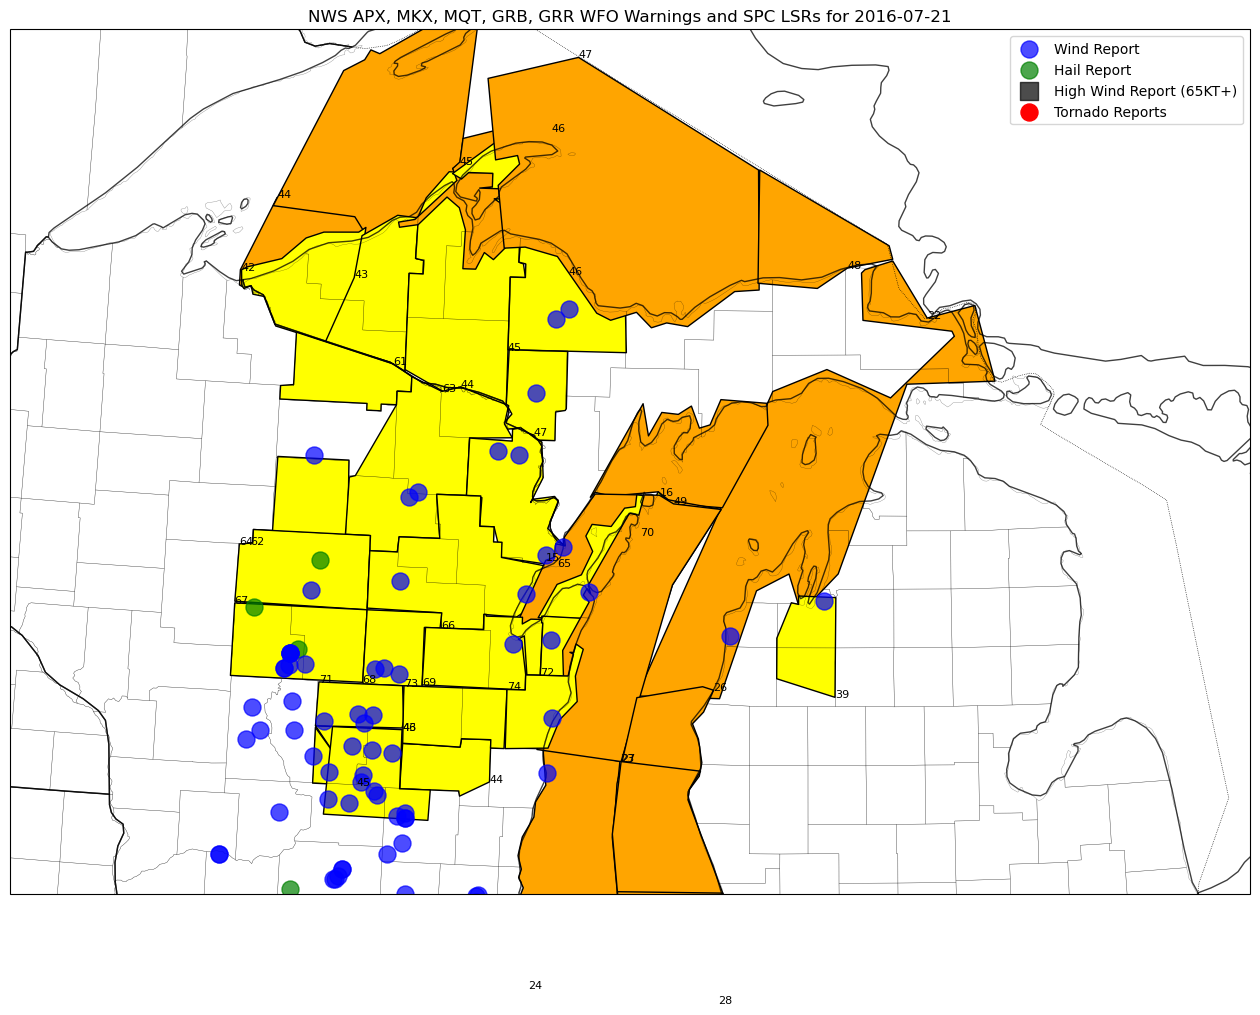

In [7]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=-85.6, central_latitude=44.3, standard_parallels=(30, 60)))
ax.set_extent([-92, -82, 43, 48])

ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'), alpha=.75)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':', linewidth=0.5)
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25, alpha = 0.5)

for i in range(len(df_wind['Speed'])):
    value = df_wind['Speed'][i]
    if value != 'UNK':
        try:
            df_wind['Speed'][i] = float(value)
        except ValueError:
            df_wind['Speed'][i] = np.nan
        
for index, row in df_hail.iterrows():
    if row['Size'] >= 200:
        ax.scatter(row['Lon'], row['Lat'],transform=ccrs.PlateCarree(), marker='^', c='black', alpha=0.7, s = 150,zorder=2, label = 'Large Hail Report (2"+)')
    else:
        ax.scatter(row['Lon'], row['Lat'],transform=ccrs.PlateCarree(), c='green', alpha=0.7, s=150,zorder=2, label='Hail Report')

for index, row in df_wind.iterrows():
    if (row['Speed'] != 'UNK' and row['Speed'] > 65):
        ax.scatter(row['Lon'], row['Lat'],transform=ccrs.PlateCarree(), marker = 's', c='black', alpha=0.7, s=150,zorder=2, label='High Wind Report (65KT+)')
    else:
        ax.scatter(row['Lon'], row['Lat'],transform=ccrs.PlateCarree(), c='blue', alpha=0.7, s=150,zorder=2, label='Wind Report')

ax.scatter(df_tor['Lon'].astype(float), df_tor['Lat'].astype(float), transform=ccrs.PlateCarree(), c='red', label='Tornado Reports', s = 150, zorder=2)

handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
plt.legend(unique_handles, unique_labels, loc='upper right')

colors = {'SV': 'yellow', 'TO': 'red', 'FF': 'green', 'MA': 'orange', 'DS': 'brown'}
zorders = {'TO': 3, 'SV': 2, 'MA': 1}

patches = []
phenomena_colors = []
plotted_warnings = df['phenomena'].unique()
plotted_warnings = set()

legend_patches = []
legend_labels = []
for warning in plotted_warnings:
    if warning in colors:
        legend_patches.append(mplPolygon([[0, 0], [1, 0], [1, 1], [0, 1]], closed=True, fc=colors[warning], lw=1, zorder=zorders[warning]))
        legend_labels.append(warning)

for index, row in df.iterrows():
    geometry = row['geometry']
    if geometry:
        if geometry['type'] == 'Polygon':
            coordinates = geometry['coordinates']
            if isinstance(coordinates[0][0], float):
                coordinates = [coordinates]
            for polygon_coords in coordinates:
                polygon = mplPolygon(polygon_coords, closed=True)
                patches.append(polygon)
                phenomena_colors.append(colors.get(row['phenomena'], 'gray'))
                ax.text(polygon_coords[0][0], polygon_coords[0][1], str(row['eventid']), transform=ccrs.PlateCarree(), fontsize=8)
        elif geometry['type'] == 'MultiPolygon':
            polygons = geometry['coordinates']
            for multipolygon_coords in polygons:
                for polygon_coords in multipolygon_coords:
                    polygon = mplPolygon(polygon_coords, closed=True)
                    patches.append(polygon)
                    phenomena_colors.append(colors.get(row['phenomena'], 'gray'))
                    ax.text(polygon_coords[0][0], polygon_coords[0][1], str(row['eventid']), transform=ccrs.PlateCarree(), fontsize=8)
    
    plotted_warnings.add(row['phenomena']) 

collection = PatchCollection(patches, facecolor=phenomena_colors, edgecolor='black', lw=1, transform=ccrs.PlateCarree())
ax.add_collection(collection)

legend_patches = []
legend_labels = []
for warning in plotted_warnings:
    if warning in colors:
        legend_patches.append(mplPolygon([[0, 0], [1, 0], [1, 1], [0, 1]], closed=True, fc=colors[warning], lw=1, zorder=zorders[warning]))
        legend_labels.append(warning)

plt.title(f'NWS {", ".join(wfos)} WFO Warnings and SPC LSRs for {"".join(date)}')  # Use parsed dates in title
plt.show()